## 4&5: Dish and Restaurant Recommender

In [51]:

import json
import re
import pandas as pd
from pprint import pprint
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

def save(data, name):
    filehandler = open(name,"wb")
    pickle.dump(data, filehandler)
    filehandler.close()
def load(name):
    filehandler = open(name, "rb")
    return pickle.load(filehandler)

folder_path = '../data/yelp_dataset_challenge_academic_dataset/'
business_path = folder_path + '/yelp_academic_dataset_business.json'
review_path = folder_path + '/yelp_academic_dataset_review.json'

In [52]:
business_id = []
restaurant_name = dict()

with open (business_path, 'r', encoding='UTF8') as f:
    for line in f.readlines():
        business_json = json.loads(line)
        
        if 'Indian' in business_json['categories']:
            data_id = business_json['business_id']
            business_id.append(data_id)
            restaurant_name[data_id] = business_json['name']
            

In [53]:
len(business_id),len(restaurant_name)

(202, 202)

In [54]:
reviews = [] 
stars = []
rest_name = []

with open (review_path, 'r', encoding='UTF8') as f:
    for line in f.readlines():
        review_json = json.loads(line)
        if review_json['business_id'] in business_id:
            reviews.append(review_json['text'])
            stars.append(review_json['stars'])
            rest_name.append(restaurant_name[review_json['business_id']])
print(len(reviews), len(stars), len(rest_name))

8230 8230 8230


In [55]:
provided_dish_names = []
with open('../data/manualAnnotationTask/Indian.label', 'r') as rf:
    for line in rf:
        #split_list = line.strip().split()
        if line.strip().split("\t")[1] == "1":
          provided_dish_names.append(line.strip().split("\t")[0])
        
print(len(provided_dish_names))

32


In [56]:
provided_dish_names

['salad bar',
 'main course',
 'south indian cuisine',
 'south asian',
 'chick peas',
 'chicken tikka',
 'deep fried',
 'street food',
 'flat bread',
 'tandoori chicken',
 'rogan josh',
 'comfort food',
 'gluten free',
 'mother india',
 'gulab jamun',
 'belly dancing',
 'basmati rice',
 'rice pudding',
 'south indian',
 'hot sauce',
 'belly dancer',
 'fried rice',
 'food court',
 'ice cream',
 'south india',
 'tomato soup',
 'indian cuisine',
 'chicken tikka masala',
 'white rice',
 'tomato sauce',
 'brown rice',
 'chicken wings']

## Mining Dishes For Recommendation

In [57]:
from tqdm import tqdm
# select dish names
# save reviews and stars for each dish
dataset = pd.DataFrame(columns=['review','star','dishes', 'restaurant'])
our_dishes = set()
our_restaurants = set()
for i in tqdm(range(len(reviews))):
    temp_dish = []
    
    for j, dish in enumerate(provided_dish_names):
        dish_list = dish.rsplit()
        pattern = re.compile(r'%s' % "\s+".join(dish_list), re.IGNORECASE)  
        if len(pattern.findall(reviews[i])) != 0:
            temp_dish.append(provided_dish_names[j])
            our_dishes.add(provided_dish_names[j])
            
    dataset = dataset.append({'review': reviews[i], 
                              'star': stars[i], 
                              'dishes': temp_dish,
                              'restaurant': rest_name[i]}, 
                              ignore_index=True)
    our_restaurants.add(rest_name[i])
    #break

100%|██████████| 8230/8230 [00:32<00:00, 252.38it/s]


In [58]:
save(dataset, 'dataset_pd.pickle')
save(our_dishes, 'our_dishes.pickle')
save(our_restaurants, 'our_restaurants.pickle')

In [59]:
dataset = dataset[dataset['dishes'].map(len) != 0]


In [60]:

dish_df = pd.DataFrame(columns=['total','1 star', '2 star', '3 star', '4 star', '5 star'])
cnt=0

for dish in our_dishes:

    filtered_df = dataset[dataset['dishes'].apply(lambda x: dish in x)]
    total = len(filtered_df)
    one = len(filtered_df[filtered_df['star']==1])
    two = len(filtered_df[filtered_df['star']==2])
    thr = len(filtered_df[filtered_df['star']==3]) 
    fou = len(filtered_df[filtered_df['star']==4])
    fiv = len(filtered_df[filtered_df['star']==5])

    dish_df.loc[dish] = [total, one, two, thr, fou, fiv]
    

In [61]:
plot_dish_df = dish_df.sort_values(by='total', ascending=False).iloc[:100]
del plot_dish_df['total']



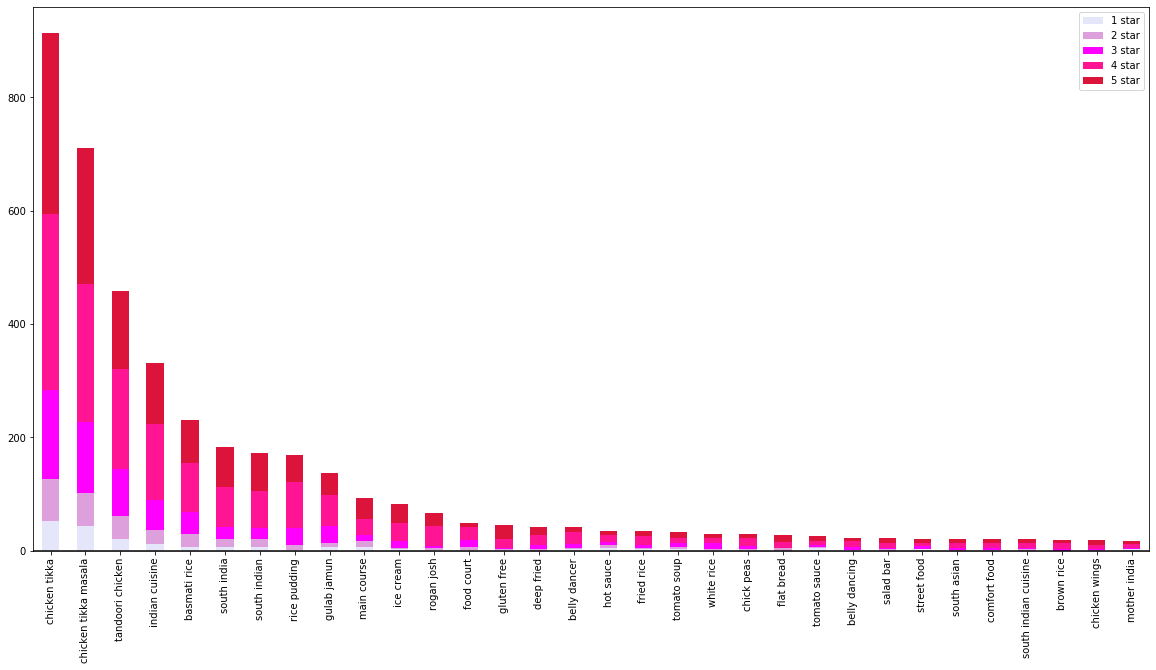

In [62]:

plot_dish_df.plot.bar(stacked=True, 
                       figsize=(20,10), 
                       color=['lavender', 'plum', 'fuchsia', 'deeppink', 'crimson',])
plt.axhline(0, color='k')

In [63]:
plot_dish_df['total'] = plot_dish_df['1 star'] + plot_dish_df['2 star'] + plot_dish_df['3 star'] + plot_dish_df['4 star'] + plot_dish_df['5 star']

In [64]:
plot_scaled_df = pd.DataFrame(columns=['1 star', '2 star', '3 star', '4 star', '5 star'])
plot_scaled_df['1 star'] = plot_dish_df['1 star'] / plot_dish_df['total']
plot_scaled_df['2 star'] = plot_dish_df['2 star'] / plot_dish_df['total']
plot_scaled_df['3 star'] = plot_dish_df['3 star'] / plot_dish_df['total']
plot_scaled_df['4 star'] = plot_dish_df['4 star'] / plot_dish_df['total']
plot_scaled_df['5 star'] = plot_dish_df['5 star'] / plot_dish_df['total']

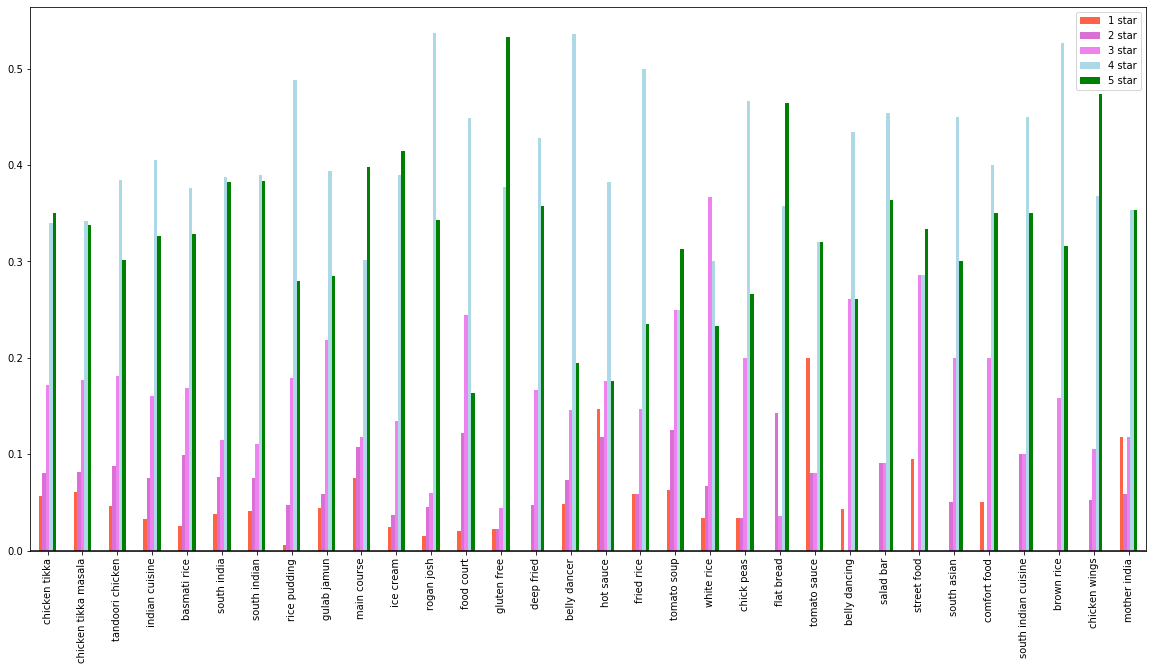

In [65]:

plot_scaled_df.plot.bar(#stacked=True, 
                        figsize=(20,10), 
                        color=['tomato', 'orchid', 'violet', 'lightblue', 'green'])
plt.axhline(0, color='k')

## Mining Restaurants For Recommendation

In [97]:
pop_dish_df = dataset[dataset['dishes'].apply(lambda x: 'chicken tikka' in x)]


In [98]:
restaurant_df = pd.DataFrame(columns=['total','1 star', '2 star', '3 star', '4 star', '5 star'])
cnt=0

for restaurant in our_restaurants:

    filtered_df = pop_dish_df[pop_dish_df['restaurant'].apply(lambda x: restaurant in x)]
    total = len(filtered_df)
    one = len(filtered_df[filtered_df['star']==1])
    two = len(filtered_df[filtered_df['star']==2])
    thr = len(filtered_df[filtered_df['star']==3]) 
    fou = len(filtered_df[filtered_df['star']==4])
    fiv = len(filtered_df[filtered_df['star']==5])

    restaurant_df.loc[restaurant] = [total, one, two, thr, fou, fiv]

In [99]:
plot_rest_df = restaurant_df.sort_values(by='total', ascending=False).iloc[:30]

print('total max:',plot_rest_df['total'].max(), ', total min:',plot_rest_df['total'].min())
del plot_rest_df['total']

total max: 70 , total min: 12


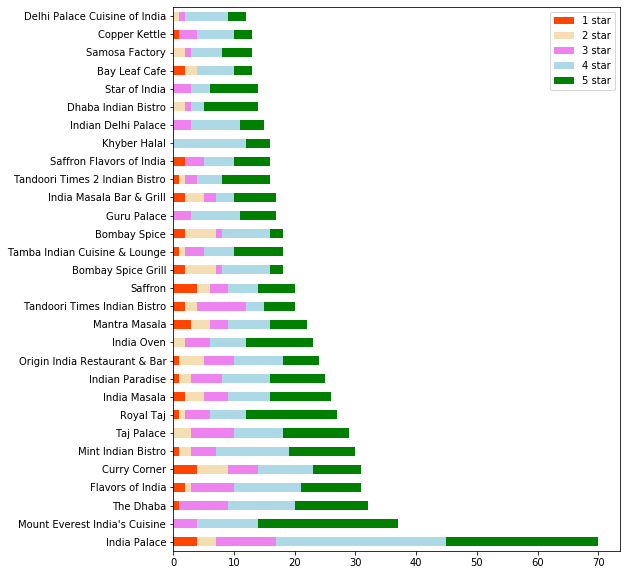

In [100]:
plot_rest_df.plot.barh(stacked=True, 
                       figsize=(8,10), 
                       color=['orangered', 'wheat', 'violet', 'lightblue', 'green'])


In [101]:
plot_rest_df['total'] = plot_rest_df['1 star'] + plot_rest_df['2 star'] + plot_rest_df['3 star'] + plot_rest_df['4 star'] + plot_rest_df['5 star']



In [102]:

plot_scaled2_df = pd.DataFrame(columns=['1 star', '2 star', '3 star', '4 star', '5 star'])
plot_scaled2_df['1 star'] = plot_rest_df['1 star'] / plot_rest_df['total']
plot_scaled2_df['2 star'] = plot_rest_df['2 star'] / plot_rest_df['total']
plot_scaled2_df['3 star'] = plot_rest_df['3 star'] / plot_rest_df['total']
plot_scaled2_df['4 star'] = plot_rest_df['4 star'] / plot_rest_df['total']
plot_scaled2_df['5 star'] = plot_rest_df['5 star'] / plot_rest_df['total']

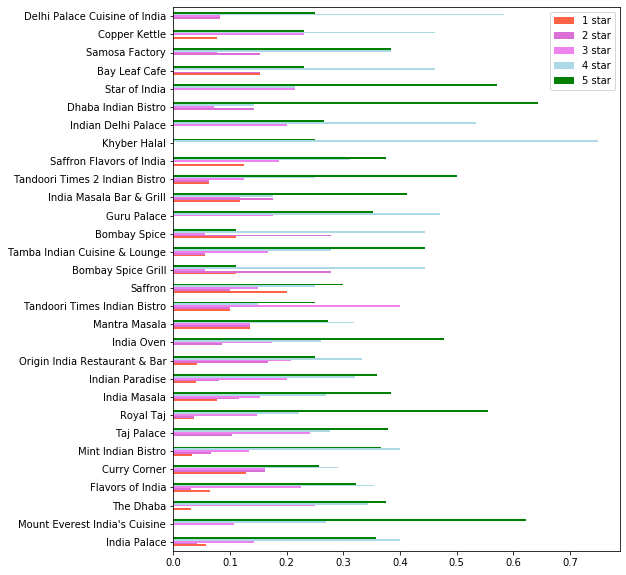

In [103]:

plot_scaled2_df.plot.barh(#stacked=True, 
                        figsize=(8,10), 
                        color=['tomato', 'orchid', 'violet', 'lightblue', 'green'])


## 5 Conclusion
Using last two figures, we came to conclusion that “Mount Everest India’s Cuisine” seems to be the best restaurant to have “Chicken Tikka” dish at. We used both plots to make this decision similarly how we did in task 4. “Mount Everest India’s Cuisine” is the second most popular restaurant by total reviews in Figure 3, and it has one of the top proportions of 5 stars in Figure 2. From this analysis we can effectively, recommend anyone to try “Mount Everest India’s Cuisine” to try “Chikken Tikka” disk.
